# Tutorial 10 - Advanced Models for PDEs

In this tutorial we will be addressing a forward PDE problem using an architecture more advanced than the standard KAN used in Tutorial 8.

In [1]:
from jaxkan.models.RGAKAN import RGAKAN

import jax
import jax.numpy as jnp

from jaxkan.pikan.pde import get_ac_res
from jaxkan.pikan.sampling import get_collocs_grid
from jaxkan.pikan.adaptive import get_colloc_indices, lr_anneal

from typing import Union, List

from flax import nnx
import optax

import matplotlib.pyplot as plt
import numpy as np

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

## Data Generation

We will once again be solving the Allen-Cahn Equation,

$$ \frac{\partial u}{\partial t} - D\frac{\partial^2 u}{\partial x^2} + 5 \left(u^3 - u\right) = 0,$$

for $D = 10^{-4}$ in the $\Omega = [0,1]\times [-1, 1]$ domain, subject to initial condition

$$ u\left(t=0, x\right) = x^2 \cos\left(\pi x\right), $$

and periodic boundary conditions

$$ u\left(t, x=-1\right) = u\left(t, x=1\right). $$

Again, we will be using adaptive training methods (see Tutorial 8 and [this](https://www.arxiv.org/abs/2510.23501) paper).

In [2]:
seed = 42

# Generate Collocation points for PDE
collocs_pool = get_collocs_grid(ranges=[(0, 1, 2**7), (-1, 1, 2**7)])

# Generate Collocation points for IC
ic_collocs = get_collocs_grid(ranges=[(0, 0, 1), (-1, 1, 2**6)])
ic_data = ((ic_collocs[:,1]**2)*jnp.cos(jnp.pi*ic_collocs[:,1])).reshape(-1,1)

## RGA KAN Model

Instead of using the vanilla KAN model, we will be using the Residual-Gated Adaptive Kolmogorv-Arnold Network introduced in [Training Deep Physics-Informed Kolmogorov-Arnold Networks](https://www.sciencedirect.com/science/article/pii/S0045782526000356). Once again, boundary conditions will be enforced directly via the model architecture, this time by applying periodical embeddings (see the API Reference of RGAKAN).

In [3]:
# Initialize an RGA KAN model
n_in = collocs_pool.shape[1]
n_out = 1
n_hidden = 8
num_blocks = 2
flavor = 'exact'
D = 5
init_scheme = {'type': 'glorot_fine'}
alpha = 0.0
beta = 0.0
ref = None
period_axes = {1 : (jnp.pi, False)}
rff_std = None
sine_D = 5

model = RGAKAN(n_in = n_in, n_out = n_out, n_hidden = n_hidden, num_blocks = num_blocks, flavor = flavor, D = D, init_scheme = init_scheme,
               alpha = alpha, beta = beta, ref = ref, period_axes = period_axes, rff_std = rff_std, sine_D = sine_D, seed = seed)


In [4]:
# We will also be using a more adaptive optimizer with learning rate scheduling
lr_schedule = optax.exponential_decay(
                init_value=1e-3,
                transition_steps=1000,
                decay_rate=0.9,
                staircase=False
            )

opt_type = optax.adam(learning_rate=lr_schedule, b1=0.9, b2=0.999, eps=1e-8)

optimizer = nnx.Optimizer(model, opt_type, wrt=nnx.Param)

## Adaptive Training

In [5]:
@nnx.jit
def get_RAD_indices(model, collocs_pool, old_indices, l_E, l_E_pool):

    # Apply updates from old indices to pool
    updated_pool = l_E_pool.at[old_indices].set(l_E)

    # Get full residuals
    resids = pde_res(model, collocs_pool)
    
    # Multiply by RBA weights
    w_resids = updated_pool * resids
    
    # Get absolute
    wa_resids = jnp.abs(w_resids)

    # Raise to power rad_a
    ea = jnp.power(wa_resids, rad_a)
    
    # Divide by mean and add rad_c
    px = (ea/jnp.mean(ea)) + rad_c
    
    # Normalize
    px_norm = (px / jnp.sum(px))[:,0]

    sorted_indices = get_colloc_indices(collocs_pool=collocs_pool, batch_size=batch_size, px=px_norm, seed=seed)

    return sorted_indices, updated_pool

In [6]:
# PDE Residual
pde_res = get_ac_res()


# PDE Loss
def pde_loss(model, l_E, collocs):

    residuals = pde_res(model, collocs) # shape (batch_size, 1)

    # Get new RBA weights
    abs_res = jnp.abs(residuals)
    l_E_new = (RBA_gamma*l_E) + (RBA_eta*abs_res/jnp.max(abs_res)) # shape (batch_size, 1)

    # Multiply by RBA weights
    w_resids = l_E_new * residuals # shape (batch_size, 1)

    # Reshape residuals for causal training
    residuals = w_resids.reshape(num_chunks, -1) # shape (num_chunks, points)

    # Get average loss per chunk
    loss = jnp.mean(residuals**2, axis=1)

    # Get causal weights
    weights = jax.lax.stop_gradient(jnp.exp(-causal_tol * (M @ loss)))

    # Weighted loss
    weighted_loss = jnp.mean(weights * loss)

    return weighted_loss, l_E_new


# IC Loss
def ic_loss(model, l_I, ic_collocs, ic_data):

    # Residual
    ic_res = model(ic_collocs) - ic_data

    # Get new RBA weights
    abs_res = jnp.abs(ic_res)
    l_I_new = (RBA_gamma*l_I) + (RBA_eta*abs_res/jnp.max(abs_res))

    # Multiply by RBA weights
    w_resids = l_I_new * ic_res

    # Loss
    loss = jnp.mean(w_resids**2)

    return loss, l_I_new


@nnx.jit
def train_step(model, optimizer, collocs, ic_collocs, ic_data, λ_E, λ_I, l_E, l_I):

    # PDE loss
    (loss_E, l_E_new), grads_E = nnx.value_and_grad(pde_loss, has_aux=True)(model, l_E, collocs)

    # IC loss
    (loss_I, l_I_new), grads_I = nnx.value_and_grad(ic_loss, has_aux=True)(model, l_I, ic_collocs, ic_data)
    
    # Compute total loss
    loss = λ_E*loss_E + λ_I*loss_I

    # Compute total gradients
    grads = jax.tree_util.tree_map(lambda g1, g2: λ_E * g1 + λ_I * g2, grads_E, grads_I)

    # Optimizer step
    optimizer.update(model, grads)

    return loss, grads_E, grads_I, l_E_new, l_I_new

In [7]:
num_epochs = 10_000

# Define causal training parameters
causal_tol = 1.0
num_chunks = 32
M = jnp.triu(jnp.ones((num_chunks, num_chunks)), k=1).T

# Define LR Annealing parameters
grad_mixing = 0.9
f_grad_norm = 1000

# Define resampling parameters
batch_size = 2**12
f_resample = 2000
rad_a = 1.0
rad_c = 1.0

# Define RBA parameters
RBA_gamma = 0.999
RBA_eta = 0.01

In [8]:
# Initialize RBA weights - full pool
l_E_pool = jnp.ones((collocs_pool.shape[0], 1))
# Also get RBAs for ICs
l_I = jnp.ones((ic_collocs.shape[0], 1))

# Get starting collocation points & RBA weights
sorted_indices = get_colloc_indices(collocs_pool=collocs_pool, batch_size=batch_size, px=None, seed=seed)

pde_collocs = collocs_pool[sorted_indices]
l_E = l_E_pool[sorted_indices]

# Define global loss weights (initialization)
λ_E = jnp.array(1.0, dtype=float)
λ_I = jnp.array(1.0, dtype=float)

Following this setup, we proceed to train the model.

In [9]:
train_losses = jnp.zeros((num_epochs,))

# Start training
for epoch in range(num_epochs):

    loss, grads_E, grads_I, l_E, l_I = train_step(model, optimizer, pde_collocs, ic_collocs, ic_data, λ_E, λ_I, l_E, l_I)

    # Perform lr annealing
    if (epoch != 0) and (epoch % f_grad_norm == 0):

        print(f"Epoch No. {epoch}. Current loss: {loss:.2e}. Performing learning-rate annealing.")

        λ_Ε, λ_I = lr_anneal(grads_E, grads_I, λ_E, λ_I, grad_mixing)

    # Perform RAD
    if (epoch != 0) and (epoch % f_resample == 0):

        print(f"Epoch No. {epoch}. Current loss: {loss:.2e}. Performing RAD resampling.")

        # Get new indices after resampling
        sorted_indices, l_E_pool = get_RAD_indices(model, collocs_pool, sorted_indices, l_E, l_E_pool)
        # Set new batch of collocs and l_E
        pde_collocs = collocs_pool[sorted_indices]
        l_E = l_E_pool[sorted_indices]

    # Append the loss
    train_losses = train_losses.at[epoch].set(loss)

Epoch No. 1000. Current loss: 1.43e-02. Performing learning-rate annealing.
Epoch No. 2000. Current loss: 3.21e-02. Performing learning-rate annealing.
Epoch No. 2000. Current loss: 3.21e-02. Performing RAD resampling.
Epoch No. 3000. Current loss: 4.12e-02. Performing learning-rate annealing.
Epoch No. 4000. Current loss: 1.16e-03. Performing learning-rate annealing.
Epoch No. 4000. Current loss: 1.16e-03. Performing RAD resampling.
Epoch No. 5000. Current loss: 7.39e-04. Performing learning-rate annealing.
Epoch No. 6000. Current loss: 4.17e-04. Performing learning-rate annealing.
Epoch No. 6000. Current loss: 4.17e-04. Performing RAD resampling.
Epoch No. 7000. Current loss: 3.62e-04. Performing learning-rate annealing.
Epoch No. 8000. Current loss: 5.37e-04. Performing learning-rate annealing.
Epoch No. 8000. Current loss: 5.37e-04. Performing RAD resampling.
Epoch No. 9000. Current loss: 2.98e-04. Performing learning-rate annealing.


## Evaluation

By visualizing the train loss curve, we can see that even when training for a significantly smaller number of epochs than in the vanilla KAN case, the loss function decreases further.

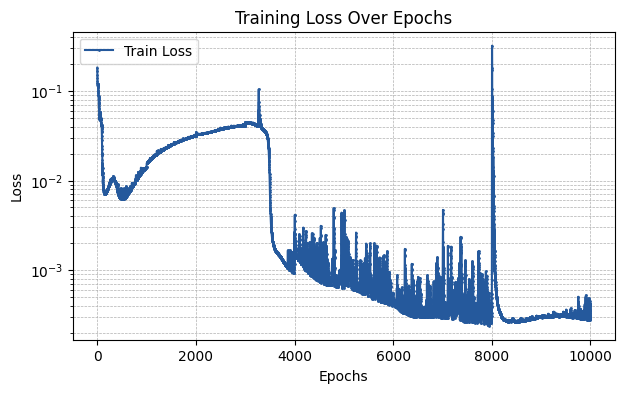

In [10]:
plt.figure(figsize=(7, 4))

plt.plot(np.array(train_losses), label='Train Loss', marker='o', color='#25599c', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

Additionally, the approximation to the actual solution is better.

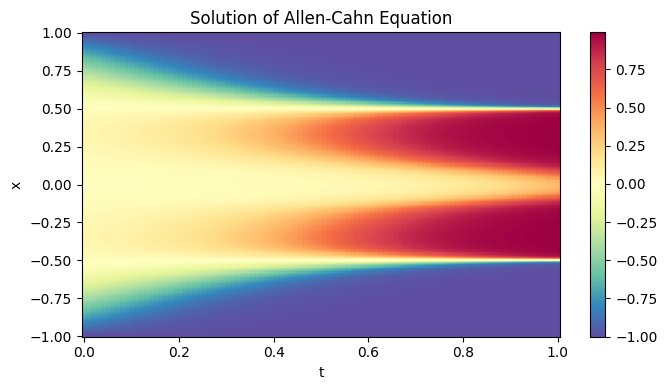

In [11]:
N_t, N_x = 100, 256

t = np.linspace(0.0, 1.0, N_t)
x = np.linspace(-1.0, 1.0, N_x)
T, X = np.meshgrid(t, x, indexing='ij')
coords = np.stack([T.flatten(), X.flatten()], axis=1)

output = model(jnp.array(coords))
resplot = np.array(output).reshape(N_t, N_x)

plt.figure(figsize=(7, 4))
plt.pcolormesh(T, X, resplot, shading='auto', cmap='Spectral_r')
plt.colorbar()

plt.title('Solution of Allen-Cahn Equation')
plt.xlabel('t')

plt.ylabel('x')

plt.tight_layout()
plt.show()